# Breast cancer detection from thermal imaging

The main purpose of this project is to develop a comprehensive decision support system for breast cancer screening.

## Library import
En esta sección se tratará de importar las librerias que se van a utilizar a lo largo de este modelo. Hay que tener en cuenta que parte de las librerías que utiliza este programa se encuentran declaradas en los ficheros que se encuentran en `src/scripts/*.py`.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from scripts import *

In [3]:
computer.check_available_devices() # Check available devices

Available devices:
- CPU: /physical_device:CPU:0
- GPU: /physical_device:GPU:0


## Data selection
To make this model work correctly it will be necessary to extract and save the images found in the `data` folder.

In this folder there are two labeled folders that contain all the images to be used:
```
data
├── healthy
└── sick
```

In [4]:
data = Data("./data/") # Data imported into a table

data.images.head(3) # Display first 3 rows

,image,category
0,./data/healthy/16-TFRON_V16_31-10-2012_8.jpg,0
1,./data/healthy/169-TFRON_V173_8-4-2013_0.jpg,0
2,./data/healthy/17-TFRON_V17_31-10-2012_6.jpg,0


## Transformation
In the transformation stage, the data is adapted to find the solution to the problem to be solved.

First of all, the data obtained previously will be divided to be able to use it for training and to check the results.

In [5]:
data.training, data.test = data.train_test_split(test_size=0.15, shuffle=True, stratify=True) # Split data into train and test

In [6]:
# The category distribution is shown for the original, training, and test data
data.count_labels(data.images, "Original")
data.count_labels(data.training, "Training")
data.count_labels(data.test, "Test")

Original: [99 96] [0.51 0.49]
Training: [84 81] [0.51 0.49]
Test: [15 15] [0.5 0.5]


Once the data is divided, different transformation techniques are applied on it to expand the size of the dataset in real time while training the model.

In [7]:
train_generator, validation_generator, test_generator = data.image_generator(shuffle=False) # Image genearation

Found 132 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


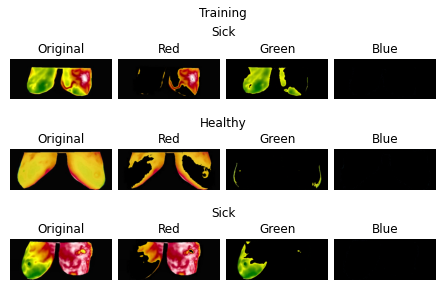

In [10]:
filters = {
	"original": lambda x: x,
	"red": lambda x: data.getImageTensor(x, (330, 0, 0), (360, 255, 255)) + data.getImageTensor(x, (0, 0, 0), (50, 255, 255)),
	"green": lambda x: data.getImageTensor(x, (60, 0, 0), (130, 255, 255)),
	"blue": lambda x: data.getImageTensor(x, (180, 0, 0), (270, 255, 255)),
}

data.show_images(train_generator, filters, "Training") # Show some images from the training generator

## Data Mining
This section seeks to apply techniques that are capable of extracting useful patterns and then evaluate them.

### Model creation
The model to be used for the next training is created.

In [30]:
red_model = Model("red", filter=filters["red"], new=False, summary=False, plot=False) # Red model creation
green_model = Model("green", filter=filters["green"], new=False, summary=False, plot=False) # Green model creation
blue_model = Model("blue", filter=filters["blue"], new=False, summary=False, plot=False) # Blue model creation

In [31]:
red_model.compile() # Compile the red model
green_model.compile() # Compile the green model
blue_model.compile() # Compile the blue model

### Model training
The created model is trained indicating the times that are going to be used.

In [34]:
red_model.fit(train_generator, validation_generator, epochs=600, verbose=False, plot=False) # Train the red model
green_model.fit(train_generator, validation_generator, epochs=600, verbose=False, plot=False) # Train the green model
blue_model.fit(train_generator, validation_generator, epochs=600, verbose=False, plot=False) # Train the blue model

Model blue -> Epoch 600/600 -> Accuracy (Validation): 0.67 -> ./output/blue/weights_012.hdf5


### Model evaluation
The trained model is evaluated using the generators created before. In this case, the best weight matrix obtained in the training will be used.

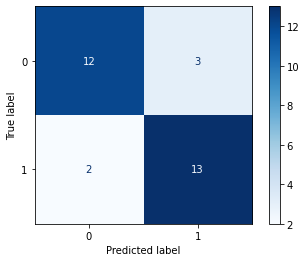

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.81      0.87      0.84        15

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.83      0.83      0.83        30

Accuracy: 0.8333
Specificity: 0.8
Sensitivity: 0.8667
Precision: 0.8125


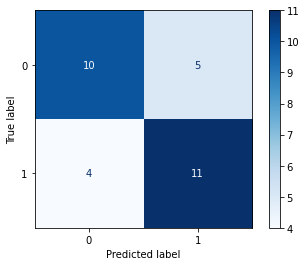

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.69      0.73      0.71        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30

Accuracy: 0.7
Specificity: 0.6667
Sensitivity: 0.7333
Precision: 0.6875


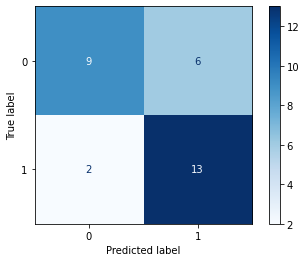

              precision    recall  f1-score   support

           0       0.82      0.60      0.69        15
           1       0.68      0.87      0.76        15

    accuracy                           0.73        30
   macro avg       0.75      0.73      0.73        30
weighted avg       0.75      0.73      0.73        30

Accuracy: 0.7333
Specificity: 0.6
Sensitivity: 0.8667
Precision: 0.6842


In [35]:
red_model.evaluate(test_generator, path=None) # Evaluate the red model
green_model.evaluate(test_generator, path=None) # Evaluate the green model
blue_model.evaluate(test_generator, path=None) # Evaluate the blue model

### Grad-CAM
An activation map of the predictions obtained by the convolutional network is displayed.

D:\ProgramData\Anaconda3\envs\hinton\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


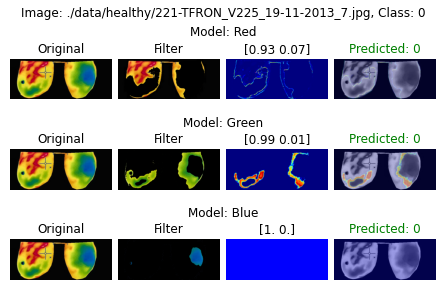

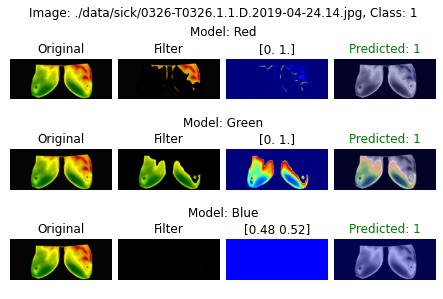

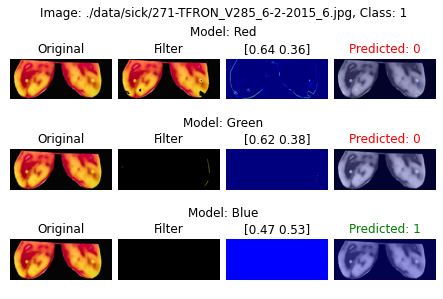

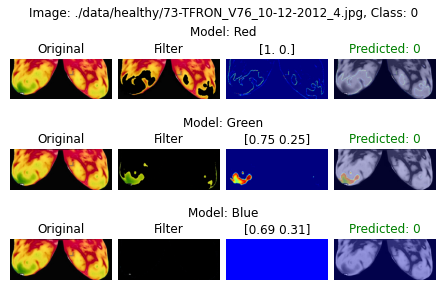

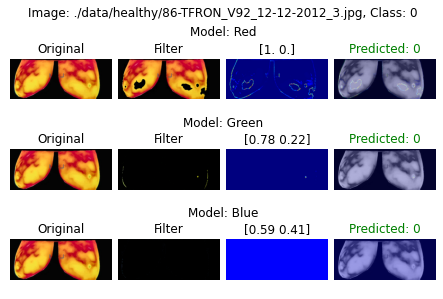

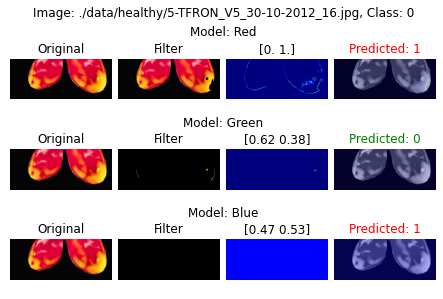

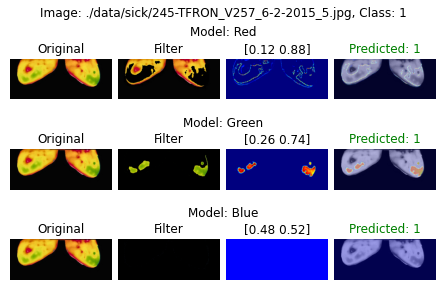

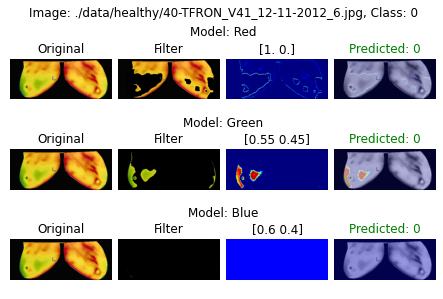

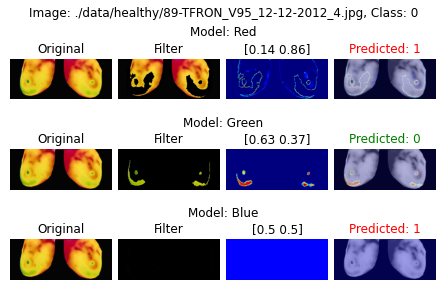

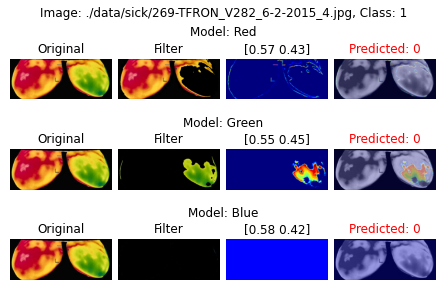

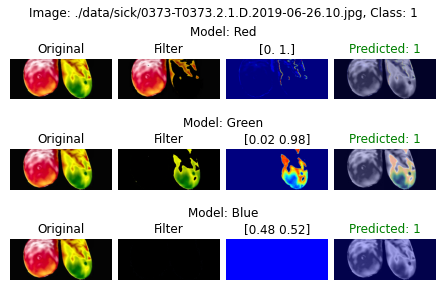

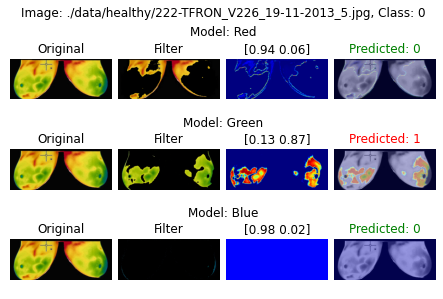

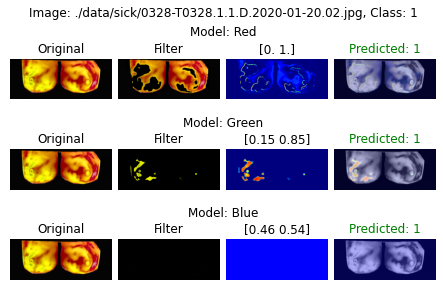

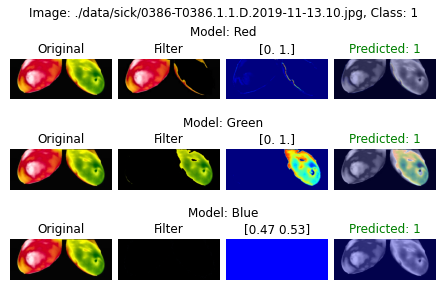

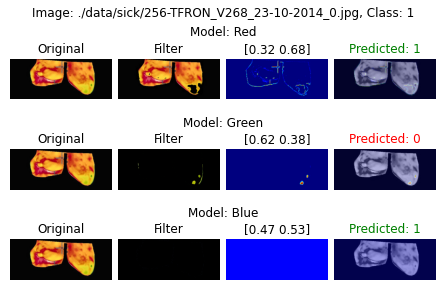

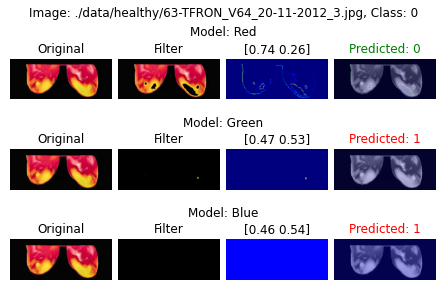

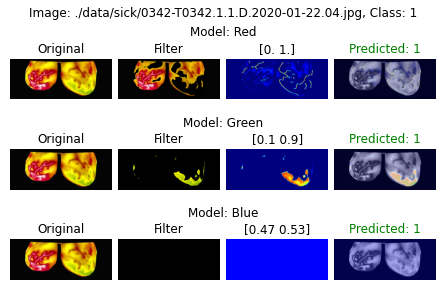

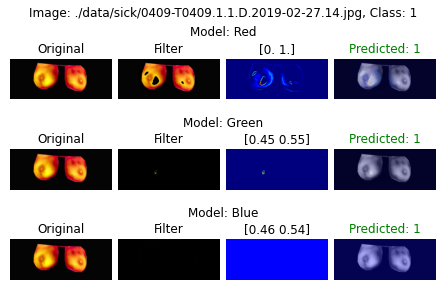

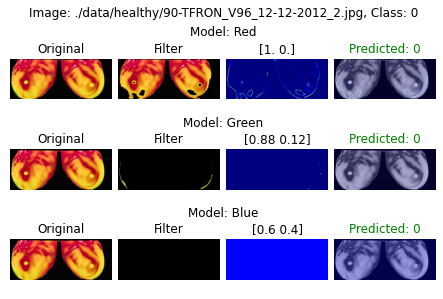

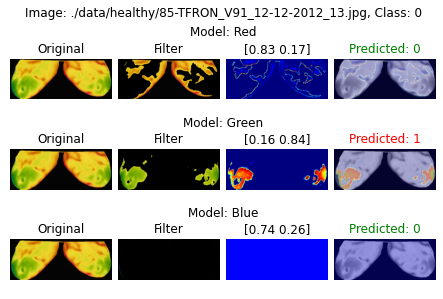

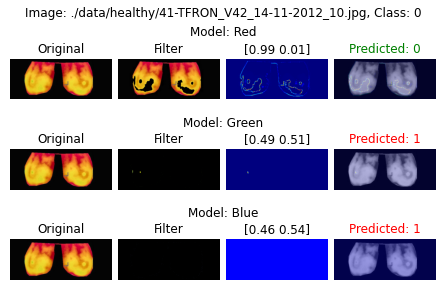

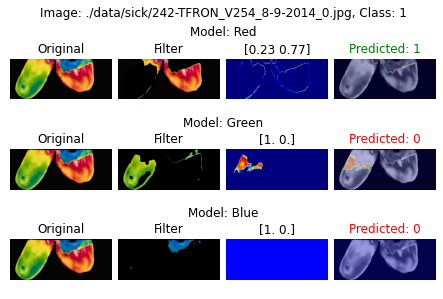

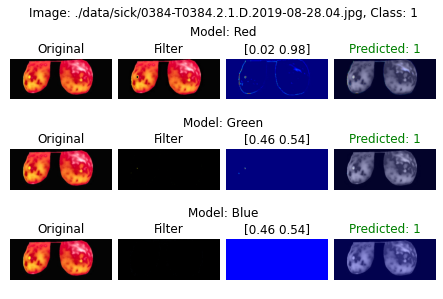

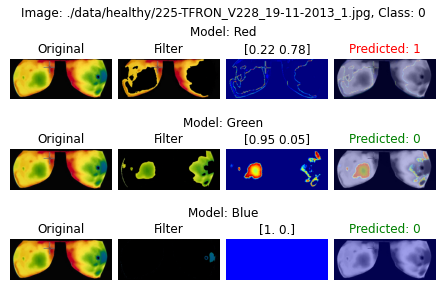

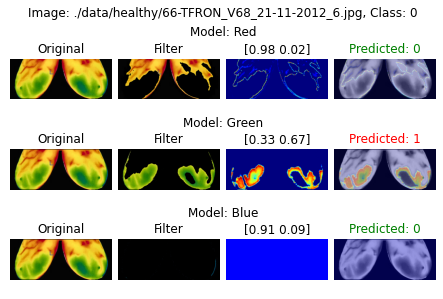

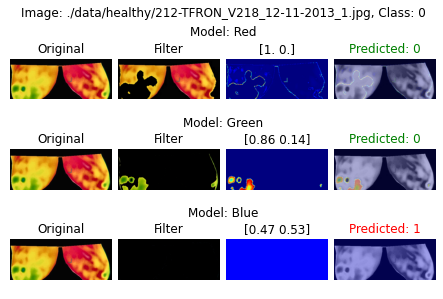

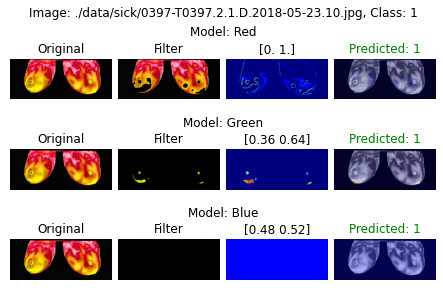

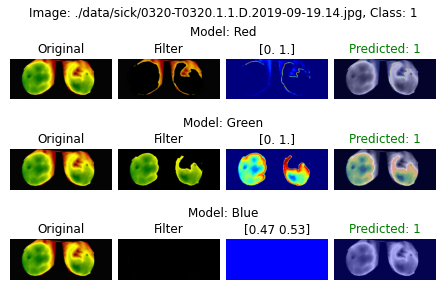

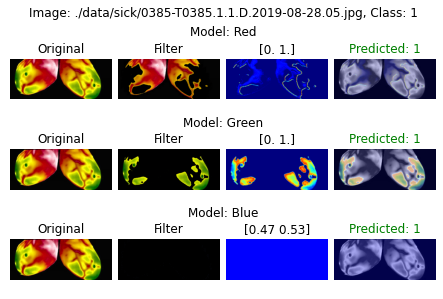

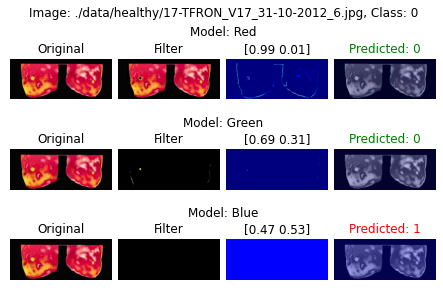

In [36]:
join_models = Join(red_model, green_model, blue_model)

# The activation map is displayed
for index, image in data.test.iterrows():
	join_models.visualize_heatmap(image)